In [1]:
import numpy as np
import torch
import torchvision
import torchmetrics
import lightning.pytorch as pl 
from torchinfo import summary 
from torchview import draw_graph 
import matplotlib.pyplot as plt 
import pandas as pd

if (torch.cuda.is_available()): 
    device = ("cuda")
else:
    device = ("cpu")
print(f"Use GPU: {torch.cuda.is_available()}")

Use GPU: True


In [2]:
# Config Section

cfg_data_folder = "datasets/cifar10"
# cfg_log_folder = "logs"
# cfg_log_version = "cifar10"

cfg_max_epochs = 50
cfg_hidden_dim = 42

cfg_cifar10_labels = {
  0: "Airplane",
  1: "Automobile",
  2: "Bird",
  3: "Cat",
  4: "Deer",
  5: "Dog",
  6: "Frog",
  7: "Horse",
  8: "Ship",
  9: "Truck",
}

cfg_num_workers = 5


In [3]:
# Load the data set and scale to [-1,+1]
training_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder, download=True, train=True)
testing_dataset = torchvision.datasets.CIFAR10(root=cfg_data_folder,  download=True, train=False) 

x_train = (torch.Tensor(training_dataset.data) / 127.5) - 1.0
y_train = torch.Tensor(training_dataset.targets).to(torch.long)
x_test = (torch.Tensor(testing_dataset.data) / 127.5) - 1.0 
y_test = torch.Tensor(testing_dataset.targets).to(torch.long)

# You can set a seed value here if you
# want to control the shuffling process...
rng = np.random.default_rng()
permutation = rng.permutation(x_train.shape[0]) 
split_point = int(x_train.shape[0] * 0.8) # 80%/20% split

# Split into validation/training - keep test # set aside for later...
x_val = x_train[permutation][split_point:]
y_val = y_train[permutation][split_point:]
x_train = x_train[permutation][:split_point]
y_train = y_train[permutation][:split_point]

print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

100%|██████████| 170498071/170498071 [00:02<00:00, 76977085.39it/s]


Extracting datasets/cifar10/cifar-10-python.tar.gz to datasets/cifar10
Files already downloaded and verified
torch.Size([40000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])
torch.Size([10000, 32, 32, 3])


In [4]:
x_train.shape

torch.Size([40000, 32, 32, 3])

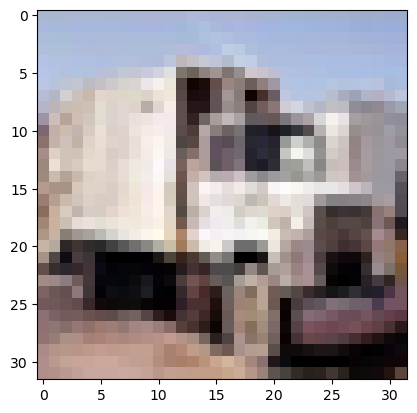

Label: Truck (idx: 9)


In [5]:
plt.imshow((x_train[0].detach().numpy() + 1.0)/2.0)
plt.show()
print(f"Label: {cfg_cifar10_labels.get(int(y_train[0]))} (idx: {y_train[0]})")

In [72]:
# Define model
class WideNetwork(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_size, **kwargs):
        super().__init__(**kwargs)
        self.flatten_layer = torch.nn.Flatten()
        self.hidden_layer = torch.nn.Linear(input_size.numel(),
                                            hidden_size)
        self.layer_norm = torch.nn.LayerNorm(hidden_size)
        self.batch_norm = torch.nn.BatchNorm1d(hidden_size)
        #self.hidden_activation = torch.nn.Tanh()
        self.hidden_activation = torch.nn.ReLU()
        self.dropout = torch.nn.Dropout(0.5)
        self.output_layer = torch.nn.Linear(hidden_size,
                                            output_size)
    
    def forward(self, x):
        y = x
        y = self.flatten_layer(y)
        y = self.hidden_activation(self.hidden_layer(y))
        #y = self.layer_norm(y)  # Adding / Applying Layer Normalization
        y = self.batch_norm(y) # Applying Batch Norm
        y = self.dropout(y)
        y = self.output_layer(y)
        return y
        
    def predict(self, x):
        y = x
        y = self.forward(y)
        y = torch.softmax(y, -1)
        return y

In [73]:
# Define Trainable Module
class PLModel(pl.LightningModule):
    def __init__(self, module, **kwargs):
        # This is the contructor, where we typically make
        # layer objects using provided arguments. 
        super().__init__(**kwargs) # Call the super class constructor 
        self.module = module
        
        # This creates an accuracy function
        self.model_acc = torchmetrics.classification.Accuracy(task='multiclass', 
                                                              num_classes=module.output_layer.out_features)
        # This creates a loss function
        self.model_loss = torch.nn.CrossEntropyLoss()
    
    def forward(self, x):
        return self.module.forward(x) 
        
    def predict(self, x):
        return self.module.predict(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

    def training_step(self, train_batch, batch_idx): 
        x, y_true = train_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true) 
        self.log('train_acc',  acc,  on_step=False, on_epoch=True)
        self.log('train_loss', loss, on_step=False, on_epoch=True) 
        return loss


    def validation_step(self, val_batch, batch_idx): 
        x, y_true = val_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred, y_true)
        loss = self.model_loss(y_pred, y_true)
        self.log('val_acc',  acc,  on_step=False, on_epoch=True)
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        return loss
        
    def test_step(self, test_batch, batch_idx):
        x, y_true = test_batch
        y_pred = self(x)
        acc = self.model_acc(y_pred,y_true)
        loss = self.model_loss(y_pred,y_true)
        self.log('test_acc',  acc,  on_step=False, on_epoch=True)
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        return loss


In [74]:
print(f"Hidden Dims: {cfg_hidden_dim}")

model = PLModel(WideNetwork(x_train.shape[1:],
                            len(y_train.unique()),
                            cfg_hidden_dim))

summary(model, input_size=(1,)+x_train.shape[1:])

Hidden Dims: 42


Layer (type:depth-idx)                   Output Shape              Param #
PLModel                                  [1, 10]                   --
├─WideNetwork: 1-1                       --                        84
│    └─Flatten: 2-1                      [1, 3072]                 --
│    └─Linear: 2-2                       [1, 42]                   129,066
│    └─ReLU: 2-3                         [1, 42]                   --
│    └─BatchNorm1d: 2-4                  [1, 42]                   84
│    └─Dropout: 2-5                      [1, 42]                   --
│    └─Linear: 2-6                       [1, 10]                   430
Total params: 129,664
Trainable params: 129,664
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.13
Input size (MB): 0.01
Forward/backward pass size (MB): 0.00
Params size (MB): 0.52
Estimated Total Size (MB): 0.53

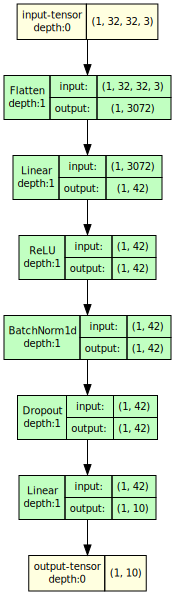

In [75]:
# Depth Setting
model_graph = draw_graph(model, input_size=(1,)+x_train.shape[1:], device=device, depth=3)

model_graph.visual_graph

In [76]:
predictions = model.predict(x_train[:5].to(device)).cpu().detach().numpy()

predictions

array([[0.02777158, 0.00794687, 0.03792859, 0.6558002 , 0.02212072,
        0.06652343, 0.02167823, 0.04167333, 0.03211709, 0.08643991],
       [0.26468974, 0.04996468, 0.02075581, 0.0448695 , 0.08066486,
        0.05094999, 0.04153159, 0.16407636, 0.17640316, 0.10609423],
       [0.05174043, 0.24006383, 0.0857658 , 0.04341688, 0.10077582,
        0.14608356, 0.07111871, 0.08752091, 0.0869561 , 0.0865579 ],
       [0.06374422, 0.10867861, 0.08630435, 0.07239814, 0.07483996,
        0.3086429 , 0.03698245, 0.07924437, 0.13289297, 0.03627196],
       [0.06635898, 0.07670902, 0.10313889, 0.04845437, 0.09889627,
        0.07083681, 0.24031201, 0.18591528, 0.01890135, 0.09047693]],
      dtype=float32)

In [77]:
model.model_loss(model(x_train[:5].to(device)),
                 y_train[:5].to(device)
                ).cpu().detach().numpy()

array(2.8679311, dtype=float32)

In [78]:
model.model_acc(model(x_train[:5].to(device)),
                y_train[:5].to(device)).cpu().detach().numpy()

array(0., dtype=float32)

In [79]:
xy_train = torch.utils.data.DataLoader(list(zip(x_train, y_train)),
                                       shuffle=True,
                                       batch_size=250,
                                       num_workers=cfg_num_workers) # Using CFG

xy_val = torch.utils.data.DataLoader(list(zip(x_val, y_val)),
                                     shuffle=False,
                                     batch_size=250,
                                     num_workers=cfg_num_workers) # Using CFG

xy_test = torch.utils.data.DataLoader(list(zip(x_test, y_test)),
                                      shuffle=False,
                                      batch_size=250,
                                      num_workers=cfg_num_workers) # Using CFG

/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [80]:
# Setup Logger
logger = pl.loggers.CSVLogger("logs", name="OL2", version="wide")

In [81]:
trainer = pl.Trainer(logger=logger,
                     max_epochs=cfg_max_epochs,
                     enable_progress_bar=True,
                     log_every_n_steps=0,
                     callbacks=[pl.callbacks.TQDMProgressBar(refresh_rate=20)])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [82]:
trainer.validate(model, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/fabric/loggers/csv_logs.py:195: UserWarning: Experiment logs directory logs/OL2/wide exists and is not empty. Previous log files in this directory will be deleted when the new ones are saved!
  rank_zero_warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │     0.093299999833107     │
│         val_loss          │     2.323897361755371     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.093299999833107, 'val_loss': 2.323897361755371}]

In [83]:
trainer.fit(model, xy_train, xy_val)

/opt/conda/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory logs/OL2/wide/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type               | Params
--------------------------------------------------
0 | module     | WideNetwork        | 129 K 
1 | model_acc  | MulticlassAccuracy | 0     
2 | model_loss | CrossEntropyLoss   | 0     
--------------------------------------------------
129 K     Trainable params
0         Non-trainable params
129 K     Total params
0.519     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [84]:
# Validate on Model
trainer.validate(model, xy_val)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃  Runningstage.validating  ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│          val_acc          │    0.48190000653266907    │
│         val_loss          │    1.4863091707229614     │
└───────────────────────────┴───────────────────────────┘

[{'val_acc': 0.48190000653266907, 'val_loss': 1.4863091707229614}]

In [85]:
results = pd.read_csv(logger.log_dir+"/metrics.csv")
results

,val_acc,val_loss,epoch,step,train_acc,train_loss
0,0.0933,2.323897,0,0,NaN,NaN
1,0.3966,1.734905,0,159,NaN,NaN
2,NaN,NaN,0,159,0.310400,1.938765
3,0.4219,1.670946,1,319,NaN,NaN
4,NaN,NaN,1,319,0.361350,1.790774
...,...,...,...,...,...,...
97,0.4758,1.497722,48,7839,NaN,NaN
98,NaN,NaN,48,7839,0.457150,1.518561
99,0.4819,1.486309,49,7999,NaN,NaN
100,NaN,NaN,49,7999,0.459475,1.516800


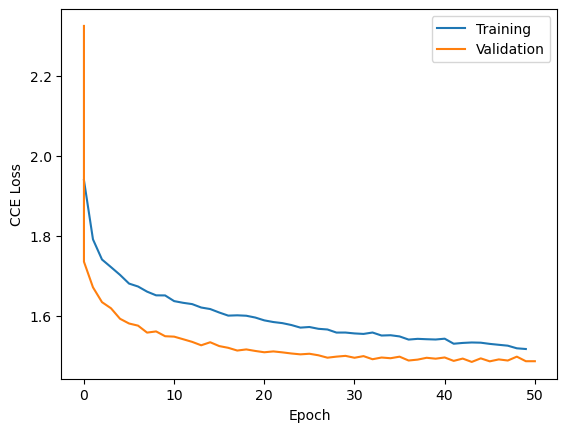

In [86]:
plt.plot(results["epoch"][np.logical_not(np.isnan(results["train_loss"]))],
         results["train_loss"][np.logical_not(np.isnan(results["train_loss"]))],
         label="Training")

plt.plot(results["epoch"][np.logical_not(np.isnan(results["val_loss"]))],
         results["val_loss"][np.logical_not(np.isnan(results["val_loss"]))],
         label="Validation")

plt.legend()
plt.ylabel("CCE Loss")
plt.xlabel("Epoch")
plt.show()

In [87]:
print("Validation accuracy:",*["%.8f"%(x) for x in results['val_acc'][np.logical_not(np.isnan(results["val_acc"]))]])

Validation accuracy: 0.09330000 0.39660001 0.42190000 0.43439999 0.44450000 0.45010000 0.45429999 0.45230001 0.46149999 0.46439999 0.46570000 0.46840000 0.46180001 0.46759999 0.47150001 0.46360001 0.46790001 0.47450000 0.47610000 0.47589999 0.47530001 0.47400001 0.47740000 0.47610000 0.47710001 0.47970000 0.47780001 0.47729999 0.47900000 0.48120001 0.47569999 0.47870001 0.47659999 0.47549999 0.47749999 0.47690001 0.47400001 0.47990000 0.47870001 0.47569999 0.48449999 0.47889999 0.47650000 0.47690001 0.48449999 0.48130000 0.48179999 0.47870001 0.48130000 0.47580001 0.48190001 0.48190001


In [88]:
print("Testing accuracy:", trainer.test(model, xy_test)[0]['test_acc'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.
/opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.47690001130104065    │
│         test_loss         │     1.481406807899475     │
└───────────────────────────┴───────────────────────────┘

Testing accuracy: 0.47690001130104065
